<a href="https://colab.research.google.com/github/stephyi/Twitter_User_Segmentation/blob/master/twitter_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Twitter Developer Account
In order to use Twitter’s API, we have to create a developer account on the Twitter apps site.
 * Log in or make a Twitter account at https://apps.twitter.com/.
 * Create a new app (button on the top right)
 
<img src=https://miro.medium.com/max/1400/0*Dq78m3JKoSqZY5SS.png style="width: 200px;">

Fill in the app creation page with a unique name, a website name (use a placeholder website if you don’t have one), and a project description. Accept the terms and conditions and proceed to the next page.

Once your project has been created, click on the “Keys and Access Tokens” tab. You should now be able to see your consumer secret and consumer key.

<img src=https://miro.medium.com/max/1400/0*YU1pFqTw6Dn-ZmOd.png style="width: 200px;">

You’ll also need a pair of access tokens. Scroll down and request those tokens. The page should refresh, and you should now have an access token and access token secret.

<img src=https://miro.medium.com/max/1400/0*_gnOgA0aaAqPgDJG.png style="width: 200px;">


## Import necessary modules

In [51]:
import sys
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

import matplotlib.dates as mdates
import seaborn as sns
#sns.set()


# to view all columns
pd.set_option("display.max.columns", None)

In [43]:
#Import the necessary methods from tweepy library  

#install tweepy if you don't have it
!pip install tweepy
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

#sentiment analysis package
!pip install textblob
from textblob import TextBlob

#general text pre-processor
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

#tweet pre-processor 
!pip install tweet-preprocessor
import preprocessor as p

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
def print_full(x):
  '''
  This is to print nicely DataFrame wide tables
  '''
  pd.set_option('display.max_rows', len(x))
  pd.set_option('display.max_columns', None)
  pd.set_option('display.width', 2000)
  pd.set_option('display.float_format', '{:20,.2f}'.format)
  pd.set_option('display.max_colwidth', -1)
  print(x)
  pd.reset_option('display.max_rows')
  pd.reset_option('display.max_columns')
  pd.reset_option('display.width')
  pd.reset_option('display.float_format')
  pd.reset_option('display.max_colwidth')

### Starting code
Below we define some starting codes (python classes and function) to illustrate and assist on how to fetch data from twitter and analyse them. 

### **Your task is**
1. Go through the code and understand it. Know what each function does
2. If you find error, fix it. Ask for help in the slack channel if you find serious mistake
3. Extend the code such that it will be useful for topics you choose to analyse
4. Make nice plots and share your finding (e.g.  insight on the main covid19 twitter converstions about your country)
5. Submit what ever you managed to do by Wednesday morning. But you should keep using what you build to write blogs, share on facebook, etc. 

In [ ]:
import twitter_credentials
import time
class tweetsearch():
    '''
    This is a basic class to search and download twitter data.
    You can build up on it to extend the functionalities for more 
    sophisticated analysis
    '''
    def __init__(self, cols=None,auth=None):
        #
        if not cols is None:
            self.cols = cols
        else:
            self.cols = ['id','created_at', 'source', 'original_text','clean_text', 
                    'sentiment','polarity','subjectivity', 'lang',
                    'favorite_count', 'retweet_count', 'original_author', 'description', 
                     'followers_count', 'friends_count','statuses_count', 
                    'possibly_sensitive', 'hashtags',
                    'user_mentions', 'place', 'place_coord_boundaries']
            
        if auth is None:
            
            #Variables that contains the user credentials to access Twitter API 
            #consumer_key = os.environ.get('TWITTER_API_KEY')
            #consumer_secret = os.environ.get('TWITTER_API_SECRET')
            #access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
            #access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
            


            #This handles Twitter authetification and the connection to Twitter Streaming API
            #auth = OAuthHandler(consumer_key, consumer_secret)
            #auth.set_access_token(access_token, access_token_secret)
            auth=OAuthHandler(twitter_credentials.CONSUMER_KEY,twitter_credentials.CONSUMER_SECRET)
            auth.set_access_token(twitter_credentials.ACCES_TOKEN,twitter_credentials.ACCES_TOKEN_SECRET)
            

       
            

        #            
        self.auth = auth
        self.api = tweepy.API(self.auth,wait_on_rate_limit=True) 
        self.filtered_tweet = ''
            

    def clean_tweets(self, twitter_text):

        #use pre processor
        tweet = p.clean(twitter_text)

         #HappyEmoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        #Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)

        #combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)

        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet)
        #after tweepy preprocessing the colon symbol left remain after      
        #removing mentions
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        #replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        #remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)

        #filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        #looping through conditions
        filtered_tweet = []    
        for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)

        return ' '.join(filtered_tweet)            

    def get_tweets(self, keyword, csvfile=None):
        
        
        df = pd.DataFrame(columns=self.cols)
        
        if not csvfile is None:
            #If the file exists, then read the existing data from the CSV file.
            if os.path.exists(csvfile):
                df = pd.read_csv(csvfile, header=0)
            

        backoff_counter=1    
        while True:
            try:
              #page attribute in tweepy.cursor and iteration
                for page in tweepy.Cursor(self.api.user_timeline, id=keyword,count=200,retry_delay=900).pages():

                    # the you receive from the Twitter API is in a JSON format and has quite an amount of information attached
                    for status in page:
                        
                        new_entry = []
                        status = status._json
                        
                        #filter by language
                        #if status['lang'] != 'en':
                        #    continue
                        # print(status.keys())
                      
                        
                        #if this tweet is a retweet update retweet count
                        if status['created_at'] in df['created_at'].values:
                            i = df.loc[df['created_at'] == status['created_at']].index[0]
                            #
                            cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                            cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                            if cond1 or cond2:
                                df.at[i, 'favorite_count'] = status['favorite_count']
                                df.at[i, 'retweet_count'] = status['retweet_count']
                            continue

                        #calculate sentiment
                        filtered_tweet = self.clean_tweets(status['text'])
                        blob = TextBlob(filtered_tweet)
                        Sentiment = blob.sentiment     
                        polarity = Sentiment.polarity
                        subjectivity = Sentiment.subjectivity

                        new_entry += [status['id'],status['created_at'],
                                      status['source'], status['text'], filtered_tweet, 
                                      Sentiment,polarity,subjectivity, status['lang'],
                                      status['favorite_count'], status['retweet_count']]
                        #followers_count-The number of followers this account currently has.
                        #freinds_count-the number of users this account is following(AKA their 'followings)
                        #statuses_count-The number of Tweets (including retweets) issued by the user
                        #favorite_count-The number of Tweets this user has liked in the account’s lifetime
                        new_entry.append(status['user']['screen_name'])
                        new_entry.append(status['user']['description'])
                        new_entry.append(status['user']['followers_count'])
                        new_entry.append(status['user']['friends_count'])
                        new_entry.append(status['user']['statuses_count'])

                        try:
                            is_sensitive = status['possibly_sensitive']
                        except KeyError:
                            is_sensitive = None

                        new_entry.append(is_sensitive)

                        hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
                        new_entry.append(hashtags) #append the hashtags

                          #
                        mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                        new_entry.append(mentions) #append the user mentions


                        try:
                            xyz = status['place']['bounding_box']['coordinates']
                            coordinates = [coord for loc in xyz for coord in loc]
                        except TypeError:
                            coordinates = None
                          #
                        new_entry.append(coordinates)

                        try:
                            location = status['user']['location']
                        except TypeError:
                            location = ''
                          #
                        new_entry.append(location)

                        

                        #now append a row to the dataframe
                        single_tweet_df = pd.DataFrame([new_entry], columns=self.cols)
                        df = df.append(single_tweet_df, ignore_index=True)
                break                                             

            
            except tweepy.TweepError as e:
                print(e.reason)
                time.sleep(60*backoff_counter)
                backoff_counter += 1
                continue

          
        #df['timestamp'] = df.created_at.map(pd.Timestamp)
        #df = df.sort_values('timestamp').set_index('timestamp')
        #df = df.drop('id',axis=1)
        
        if not csvfile is None:
            #save it to file
            df.to_csv(csvfile, columns=self.cols, index=True, encoding="utf-8")
            

        return df

In [ ]:
#Tried importing another notebook
#!python '/content/drive/My Drive/Colab Notebooks/scrapping_starter_notebook.py'
##Getting the tweets for the 100 most influential users and governemnt officials

df=pd.read_csv('100_influencers.csv')
df.head(5)

,handles
0,@Trevornoah
1,@GarethCliff
2,@SAPresident
3,@News24
4,@Julius_S_Malema


In [ ]:
twitter_handles = df['handles']  
tweets_file='influencers_tweets.csv'

if len(twitter_handles) > 0:
  ts = tweetsearch()
  for handle in twitter_handles:
     handle=re.sub(r'@',"",handle)
     df = ts.get_tweets(handle, csvfile=tweets_file) 
     print(handle)


   

Trevornoah
GarethCliff
SAPresident
News24
Julius_S_Malema
helenzille
mailandguardian
5FM
loyisogola
Computicket
MTVbaseAfrica
OfficialCSA


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,8,14,15,21) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


UlrichJvV


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,8,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


euphonik
BBCAndrewH
Camfed


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


BobSkinstad
SamsungSA
liveamp
hartleyr
SmithInAfrica
gertjohan
_AfricanUnion
SandtonCity
ParliamentofRSA
Mo_IbrahimFdn
NDOCKenya
PeterGreste
JendayiFrazer
art2gee
IECSouthAfrica
forbesafrica
Entrepreneur_SA
geoffreyyork
HenleyAfrica
IFCAfrica


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,8,14,15,20) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


africaprogress
MbuyiseniNdlozi
FoodBlogCT
AfricaResearch
MadeItInAfrica
cnbcafrica
willintune
AfricaGoodNews
ThinkAfricaFeed
CityofJoburgZA


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,1,8,14,15,20) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


theafricareport
schneiderhome
TheStar_news
rangerdiaries
daniel_howden
Aynte
GautengProvince
TechCentral
pressfreedom
africamedia_CPJ
savetherhino
mary_harper


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,8,14,15,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


okayafrica
africagathering


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,1,8,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


MercedesBenz_SA
ayittey
cx73
africatechie
Hamza_Africa
ONEinAfrica
audisouthafrica
thisisafrica
jaxpanik
forbeesta
t_mcconnell
equal_education
mikestopforth
iamsuede
JamalMOsman
KahnMorbee
artsouthafrica
malonebarry
InvestInAfrica


## Analysis of Government Officials

---



In [46]:
## reading the tweets from the csv file
gvt_tweets=pd.read_csv('all_tweets.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,8,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
gvt_tweets.head(5)

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,description,followers_count,friends_count,statuses_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,0,1282761976343662593,Mon Jul 13 19:41:02 +0000 2020,"<a href=""https://about.twitter.com/products/tw...",Actual video footage of me starting off the we...,Actual video footage starting week,"Sentiment(polarity=0.0, subjectivity=0.1)",0.00,0.1,en,20686.0,2732.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,False,NaN,NaN,NaN,"New York, NY"
1,1,1282073950843858944,Sat Jul 11 22:07:04 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @KingBach: https://t.co/Sj2sVP7Gdt,NaN,"Sentiment(polarity=0.0, subjectivity=0.0)",0.00,0.0,und,0.0,92827.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,False,NaN,KingBach,NaN,"New York, NY"
2,2,1280514534155923459,Tue Jul 07 14:50:30 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",When white people take “being an ally” too far...,When white people take ally far,"Sentiment(polarity=0.05, subjectivity=0.5)",0.05,0.5,en,43323.0,5996.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,False,NaN,NaN,NaN,"New York, NY"
3,3,1280258784485572611,Mon Jul 06 21:54:14 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Me at the restaurant after things return to no...,Me restaurant things return normal,"Sentiment(polarity=0.15, subjectivity=0.649999...",0.15,0.6499999999999999,en,14655.0,1637.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,False,NaN,NaN,NaN,"New York, NY"
4,4,1276561514456113152,Fri Jun 26 17:02:37 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @franklinleonard: “I have rape-colored skin...,I rape-colored skin,"Sentiment(polarity=0.0, subjectivity=0.0)",0.00,0.0,en,0.0,404.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,False,NaN,franklinleonard,NaN,"New York, NY"


In [48]:
gvt_tweets.shape

(97437, 22)

In [49]:
#Dropping null values in the original_text column
gvt_tweets['clean_text'].dropna(inplace=True,how=all)
gvt_tweets['clean_text'].isnull().sum()


0

In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

final_stopwords=stopwords.words('english')+ stopwords.words('french')

def tweet_tokenizer(verbatim):
    try:
        tokenizer = TweetTokenizer()
        all_tokens = tokenizer.tokenize(verbatim.lower())
        # this line filters out all tokens that are entirely non-alphabetic characters
        filtered_tokens = [t for t in all_tokens if t.islower()]
        # filter out all tokens that are <=2 chars
        filtered_tokens = [x for x in filtered_tokens if len(x)>2]
    except IndexError:
        filtered_tokens = []
    return(filtered_tokens)


# get the most common words in Tweets
from sklearn.feature_extraction.text import CountVectorizer

def get_frequent_terms(text_series, stop_words = None, ngram_range = (1,2)):
    '''
    Input:
       text_series: a list or series of documents
       stop_words: a list of stop_words to ignore, or the string 'english',
                   which uses a built-in stop word list for the english language.
                   By default, there are no stop words used
       ngram_range: a single int, or a 2 tuple representing the range of ngrams to count.
                    the default (1,2) counts 1- and 2- grams.
    Returns:
       a dataframe of counts, indexed by n-gram
    '''
    count_vectorizer = CountVectorizer(analyzer = "word",
                                       tokenizer = tweet_tokenizer,
                                       stop_words = stop_words, # try changing the stopword sets that we use.
                                                                # notice that many top terms are words like
                                                                # "and" and "the"
                                       ngram_range = ngram_range # you can change this to count frequencies of
                                                           # ngrams as well as single tokens
                                                           # a range of (1,2) counts 1-grams (single tokens) and
                                                           # 2-grams (2-token phrases)
                                      )
    term_freq_matrix = count_vectorizer.fit_transform(text_series)
    terms = count_vectorizer.get_feature_names()
    term_frequencies = term_freq_matrix.sum(axis = 0).tolist()[0]

    term_freq_df = (pd.DataFrame(list(zip(terms, term_frequencies)), columns = ["token","count"])
                    .set_index("token")
                    .sort_values("count",ascending = False))
    return term_freq_df

In [ ]:
term_freq_df = get_frequent_terms(gvt_tweets["clean_text"],
                                  stop_words =final_stopwords ) # stop_words = "english" removes words like 'and'

In [ ]:
term_freq_df.head(30)

,count
token,
president,8523
amp,6019
today,3652
prsident,3244
people,3184
minister,2648
new,2617
thank,2573
government,2188


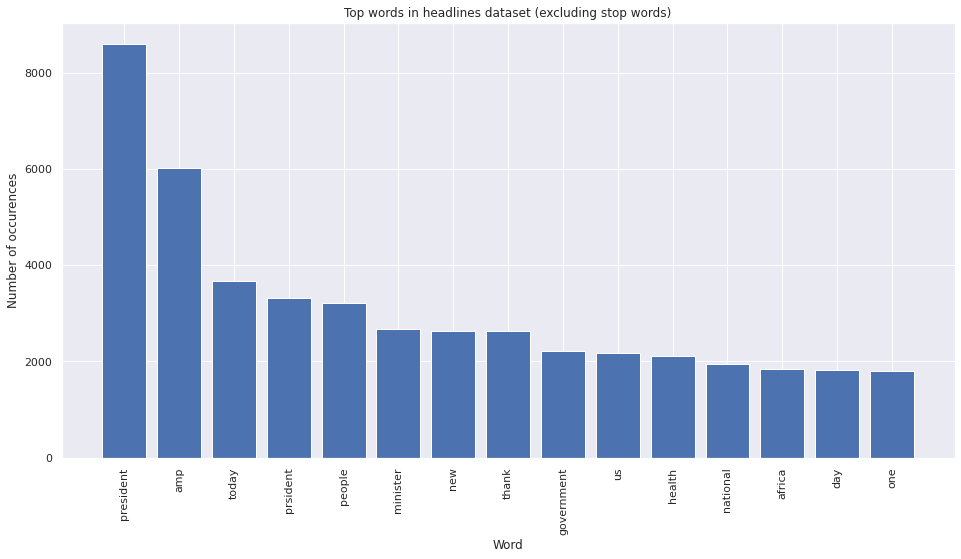

In [ ]:
import gensim
import gensim.corpora as corpora

data=gvt_tweets.clean_text.values.tolist()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# NLTK Stop words

stop_words = final_stopwords
stop_words.extend(['nan'])

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values.astype('U'))
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])



count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=gvt_tweets.clean_text)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

[('Thank', 217), ('Thank ...', 82), ('``', 44), ('Thank u', 41), ('Media briefing', 40), ('Thank u ...', 39), ('Thanks', 37), ('Retrouvez en lecture et en tlchargement libre le compte rendu du Conseil', 37), ('Merci', 32), ('//', 27)]


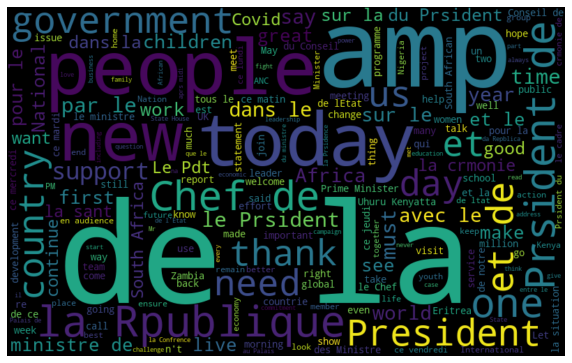

In [ ]:
from collections import Counter
from wordcloud import WordCloud
##Analyzing highest occuring words term frequency
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(max_features=1000,stop_words=final_stopwords)
tfidf=tfidf_vectorizer.fit_transform(gvt_tweets['clean_text'])

##Count most common frequent words
Counter=Counter(gvt_tweets['clean_text'])
most_occur=Counter.most_common(10)
print(most_occur)

##Visualization on word cloud
all_words=''.join([text for text in gvt_tweets['clean_text']])
wordcloud=WordCloud(width=800,height=500,max_font_size=200).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
##Checking if there are users who talk about sports
gvt_tweets['contains_sports']=pd.Series(gvt_tweets['clean_text']).str.contains('sport') & pd.Series(gvt_tweets['clean_text']).str.contains('fitness')& pd.Series(gvt_tweets['clean_text']).str.contains('fit')
gvt_tweets[(gvt_tweets['contains_sports']==True)]['original_author'].unique()

array(['helenzille', 'KagutaMuseveni'], dtype=object)

In [55]:
##Getting the maximum retweet_count for the users
retweets=(gvt_tweets[["original_author","retweet_count","hashtags"]]
    .sort_values("retweet_count",ascending = False)
    .groupby("original_author")
    .agg({"retweet_count":"max",'hashtags':'first'})
    
).head(15)

In [56]:
retweets[5:10]

,retweet_count,hashtags
original_author,,
BorisJohnson,127873.0,"coronavirus, StayHomeSaveLives"
CheikhGhazouani,1115.0,NaN
Cherif_MZ,2408.0,"Brussels, Maelbeek"
ChitaluChilufy3,0.0,NaN
CyrilRamaphosa,6869.0,WebbEllisCup


In [54]:
from collections import Counter

print("Most mentioned Twitter users:")
for item, count in Counter(gvt_tweets['user_mentions']).most_common(10):
    print(str(item) + "\t" + str(count))

print('----------------------------------------')
   
print("Most used hashtags:")
for item, count in Counter(gvt_tweets['hashtags']).most_common(10):
    print(str(item) + "\t" + str(count))

print('----------------------------------------')
print("Top 10 retweets:")

for item, count in Counter(gvt_tweets['retweet_count']).most_common(10):
      print(str(item) + "\t" + str(count))
     

Most mentioned Twitter users:
nan	55666
Presidenceci	1212
PresidencyZA	1079
gouvbenin	974
CyrilRamaphosa	618
PresidencyZA, CyrilRamaphosa	398
MYANC	362
APMutharika	338
CliffCentralCom	314
NGRPresident	313
----------------------------------------
Most used hashtags:
nan	63835
COVID19	1661
Ramaphosa	1655
IBK	1061
Burundi	746
Eritrea	478
Malawi	376
RDC	364
prci	325
DirectABO	251
----------------------------------------
Top 10 retweets:
0.0	8642
1.0	4601
2.0	3956
3.0	3602
4.0	3514
5.0	3336
6.0	3055
7.0	2686
8.0	2422
9.0	2139


#### Grouping by top retweets then hashtags


In [57]:
df1=gvt_tweets.sort_values(by=['original_author','retweet_count'],ascending=False).groupby('original_author').head(10)

In [58]:
df1.head(5)

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,description,followers_count,friends_count,statuses_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
66925,66925,1246142199529639937,Fri Apr 03 18:27:07 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @didierdrogba: It is totally inconceivable ...,It totally inconceivable keep cautioning this....,"Sentiment(polarity=0.0625, subjectivity=0.75)",0.0625,0.75,en,0.0,20040.0,willynyamitwe,Ambassador & Senior Advisor to HE @GeneralNeva...,107299,4654,40666.0,NaN,NaN,didierdrogba,NaN,"Burundi, Bujumbura"
67055,67055,1238889794874327040,Sat Mar 14 18:08:39 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @Frebouat: On aime beaucoup trop pointer du...,On aime beaucoup trop pointer du doigt les Chi...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.0,fr,0.0,11375.0,willynyamitwe,Ambassador & Senior Advisor to HE @GeneralNeva...,107299,4654,40666.0,NaN,NaN,Frebouat,NaN,"Burundi, Bujumbura"
66574,66574,1270359911575281665,Tue Jun 09 14:19:39 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @BurundiGov: URGENT: Le Gouvernement de la ...,URGENT Le Gouvernement de la Rpublique du Buru...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.0,fr,0.0,3005.0,willynyamitwe,Ambassador & Senior Advisor to HE @GeneralNeva...,107299,4654,40666.0,NaN,NaN,BurundiGov,NaN,"Burundi, Bujumbura"
66496,66496,1270580369801216001,Wed Jun 10 04:55:41 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @NicolasMaduro: Expresamos nuestras condole...,Expresamos nuestras condolencias al pueblo de ...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.0,es,0.0,2768.0,willynyamitwe,Ambassador & Senior Advisor to HE @GeneralNeva...,107299,4654,40666.0,NaN,NaN,NicolasMaduro,NaN,"Burundi, Bujumbura"
69063,69063,1163648074784358400,Tue Aug 20 03:04:55 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",RT @dodo: This baby pit bull couldn't even sta...,This baby pit bull could n't even stand decide...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0000,0.0,en,0.0,2300.0,willynyamitwe,Ambassador & Senior Advisor to HE @GeneralNeva...,107300,4654,40666.0,False,NaN,dodo,NaN,"Burundi, Bujumbura"


Text(0.5, 1.0, 'Top 5 trending hashtags')

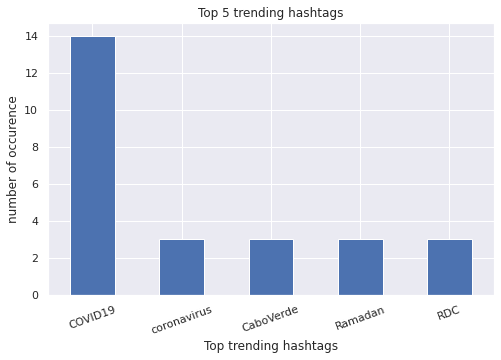

In [63]:
#Top trending hashtags and visualizing a bar graph
fig,ax=plt.subplots()
plt.xlabel('Top trending hashtags')
df1['hashtags'].value_counts().head(5).plot(ax=ax,kind='bar',figsize=(8,5),rot=20)
plt.ylabel('number of occurence')
plt.title('Top 5 trending hashtags')


In [60]:
print("Most used hashtags:")
for item, count in Counter(df1['hashtags']).most_common(6):
    print(str(item) + "\t" + str(count))

Most used hashtags:
nan	392
COVID19	14
Ramadan	3
coronavirus	3
CaboVerde	3
RDC	3


In [ ]:
gvt_tweets.grouby(['hashtags','user']).agg({'user':['count']})

#### Calculating the popularity score

In [65]:
##Some of my followers_count 
gvt_tweets['followers_count'].unique()

array(['10803489', '10803490', '1974516', '1974491', nan,
       'Zimbabwe, zimbabwecoup', '18', '3575634', '3126487', '3126488',
       '3126489', '3126490', '1443238', '1443237', '11284', '39185',
       '39186', 'Malawi', '192198', '126', '1597771', '1597772', '40771',
       '470', '1596', '609', '28981', '3469', '7137', '545623', '2922',
       2922, 66003, 1102748, 1102749, 1102760, 1102750, 1102751, 1102752,
       1102753, 1102754, 8100690, 8100691, 8100692, 8100694, 8100693,
       8100696, 8100695, 8100697, 8100698, 8100700, 8100702, 8100703,
       8100704, 1373726, 1373728, 1373730, 867278, 867279, 339891, 339890,
       1484875, 1484876, 1484877, 2908716, 2908714, 2908715, 2908717,
       2908719, 2908721, 2908722, 2908723, 2908724, 2908725, 2908726,
       205041, 1981947, 1981948, 1981949, 1981951, 423332, 2541, 370017,
       370018, 4014, 1810772, 1810774, 1810775, 1810776, 1810777, 1810778,
       1810779, 1810782, 3270, '3270', '107299', '107300', '18463',
       '17

In [66]:
gvt_tweets=gvt_tweets.loc[~gvt_tweets.followers_count.str.contains('Zimbabwe, zimbabwecoup',na=False)]
gvt_tweets=gvt_tweets.loc[~gvt_tweets.followers_count.str.contains('Malawi',na=False)]
gvt_tweets=gvt_tweets.loc[~gvt_tweets.followers_count.str.contains('ToAbaPa, Vote4Change',na=False)]


In [67]:
gvt_tweets['followers_count'].dropna(inplace=True)
gvt_tweets['followers_count'].fillna(0,inplace=True)

In [68]:
gvt_tweets.head(10)

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,description,followers_count,friends_count,statuses_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,0,1282761976343662593,Mon Jul 13 19:41:02 +0000 2020,"<a href=""https://about.twitter.com/products/tw...",Actual video footage of me starting off the we...,Actual video footage starting week,"Sentiment(polarity=0.0, subjectivity=0.1)",0.000000,0.1,en,20686.0,2732.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,False,NaN,NaN,NaN,"New York, NY"
1,1,1282073950843858944,Sat Jul 11 22:07:04 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @KingBach: https://t.co/Sj2sVP7Gdt,NaN,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.0,und,0.0,92827.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,False,NaN,KingBach,NaN,"New York, NY"
2,2,1280514534155923459,Tue Jul 07 14:50:30 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",When white people take “being an ally” too far...,When white people take ally far,"Sentiment(polarity=0.05, subjectivity=0.5)",0.050000,0.5,en,43323.0,5996.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,False,NaN,NaN,NaN,"New York, NY"
3,3,1280258784485572611,Mon Jul 06 21:54:14 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Me at the restaurant after things return to no...,Me restaurant things return normal,"Sentiment(polarity=0.15, subjectivity=0.649999...",0.150000,0.6499999999999999,en,14655.0,1637.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,False,NaN,NaN,NaN,"New York, NY"
4,4,1276561514456113152,Fri Jun 26 17:02:37 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @franklinleonard: “I have rape-colored skin...,I rape-colored skin,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.0,en,0.0,404.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,False,NaN,franklinleonard,NaN,"New York, NY"
5,5,1276532276659175425,Fri Jun 26 15:06:26 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",There are people fighting to walk around a sup...,There people fighting walk around supermarket ...,"Sentiment(polarity=0.2857142857142857, subject...",0.285714,0.5357142857142857,en,34264.0,4981.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,NaN,NaN,NaN,NaN,"New York, NY"
6,6,1276529543289942016,Fri Jun 26 14:55:34 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @SawyerHackett: Never would have thought a ...,Never would thought Tik Tok qualified immunity...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.0,en,0.0,56888.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,False,NaN,SawyerHackett,NaN,"New York, NY"
7,7,1276300649630773253,Thu Jun 25 23:46:02 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",@kimlatricejones @DEADLINE 🙌🏽,NaN,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.0,und,60.0,4.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,NaN,NaN,"kimlatricejones, DEADLINE",NaN,"New York, NY"
8,8,1276247505450270720,Thu Jun 25 20:14:51 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @Sensational_Dre: So a person with a felony...,So person felony cant vote still counted censu...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.0,en,0.0,102295.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10803489,325,11185.0,NaN,NaN,Sensational_Dre,NaN,"New York, NY"
9,9,1276197629794410498,Thu Jun 25 16:56:40 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @maleeezy_: a story in two parts: https://t...,story two parts,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.0,en,0.0,161675.0,Trevor

In [69]:
gvt_tweets['Followers'] = gvt_tweets['followers_count'].apply(lambda x:int(x))

In [70]:
gvt_tweets.groupby(['original_author'])['Followers'].max()

original_author
2884.0                    NaN
AOuattara_PRCI       830895.0
BorisJohnson        2908726.0
CheikhGhazouani       31743.0
Cherif_MZ             18463.0
ChitaluChilufy3         470.0
CyrilRamaphosa      1484877.0
Dora_Siliya           40771.0
EswatiniGovern1       11284.0
FinanceSC               126.0
GarethCliff         1974516.0
IssoufouMhm          116073.0
Julius_S_Malema     3126490.0
KGeorgieva           205041.0
KagutaMuseveni      1810782.0
MBuhari             3269481.0
MSPS_Togo              1129.0
M_Farmaajo           423332.0
Macky_Sall          1373730.0
MagufuliJP           867279.0
MalawiGovt            39186.0
MinSantedj             2922.0
NAkufoAddo          1505668.0
News24              3575634.0
PaulKagame          1981951.0
PresidenceBenin       30111.0
PresidenceMali       228642.0
Presidence_RDC       339891.0
PresidenciaCV          3281.0
PresidencyZA        1597772.0
Presidency_GMB        10718.0
PresidentABO         173303.0
PresidentBio          14

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

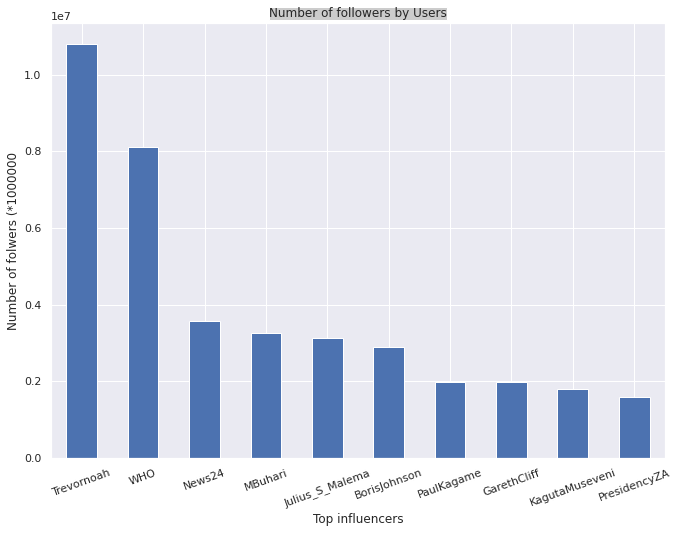

In [76]:
import matplotlib.pyplot as plot

followers_by_users = gvt_tweets.groupby(['original_author'])['Followers'].max().sort_values(ascending=False).head(10)
plt.title('Number of followers by Users', bbox={'facecolor':'0.8', 'pad':0})
followers_by_users.plot(kind='bar',figsize=(11, 8))
plt.ylabel('Number of folwers (*1000000')
plt.xlabel('Top influencers')
plt.xticks(rotation=20)

In [77]:
##getting the number of people who they follow(friends_count)
gvt_tweets['friends_count'].unique()

array(['325', '356', nan, '14', '631', '652', '2304', '82', '26', '55',
       '224', '13', '870', '891', 'acarvin, NickKristof, MiaFarrow', '69',
       '1077', '190', '95', '116', '127', 127, 434, 214, 1725, 171, 8,
       125, 6, 458, 2313, 181, 2, 463, 115, 32, 28, 312, '312', '4654',
       '195', '4', '101', '66', '151', '885', '23', '27', '352', '29',
       '181', '1001', '9', '17', '0', '2'], dtype=object)

In [78]:
gvt_tweets=gvt_tweets.loc[~gvt_tweets.friends_count.str.contains('JayShantaram',na=False)]
gvt_tweets=gvt_tweets.loc[~gvt_tweets.friends_count.str.contains('acarvin, NickKristof, MiaFarrow',na=False)]
gvt_tweets=gvt_tweets.loc[~gvt_tweets.friends_count.str.contains('angel_jnr101, NAkufoAddo',na=False)]


In [82]:
gvt_tweets['friends_count'].dropna(inplace=True)
gvt_tweets['friends_count'].fillna(0,inplace=True)

gvt_tweets['Following'] = gvt_tweets['friends_count'].apply(lambda x:int(x)).reset_index()

In [83]:
gvt_tweets.groupby(['original_author'])['Following'].max()

original_author
AOuattara_PRCI     85261.0
BorisJohnson       53875.0
CheikhGhazouani    93803.0
Cherif_MZ          70049.0
ChitaluChilufy3    25115.0
CyrilRamaphosa     50702.0
Dora_Siliya        25114.0
EswatiniGovern1    17555.0
FinanceSC          21936.0
GarethCliff         6350.0
IssoufouMhm        94149.0
Julius_S_Malema    12787.0
KGeorgieva         57044.0
KagutaMuseveni     65372.0
MBuhari            97318.0
MSPS_Togo          97436.0
M_Farmaajo         60496.0
Macky_Sall         45706.0
MagufuliJP         45931.0
MalawiGovt         20734.0
MinSantedj         33465.0
NAkufoAddo         89719.0
News24              9579.0
PaulKagame         59898.0
PresidenceBenin    78116.0
PresidenceMali     93773.0
Presidence_RDC     47498.0
PresidenciaCV      82041.0
PresidencyZA       24824.0
Presidency_GMB     86602.0
PresidentABO       71776.0
PresidentBio       97401.0
SAPresident         6369.0
SouthSudanGov      60703.0
StateHouseKenya    39886.0
SudanPMHamdok      61336.0
TZSpokespers

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

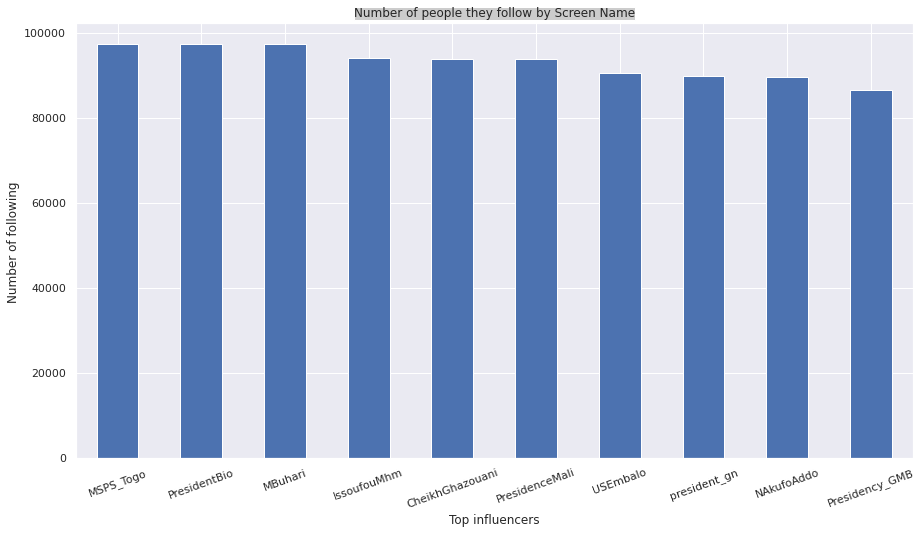

In [86]:
import matplotlib.pyplot as plot

followers_by_users = gvt_tweets.groupby(['original_author'])['Following'].max().sort_values(ascending=False).head(10)
plt.title('Number of people they follow by Screen Name', bbox={'facecolor':'0.8', 'pad':0})
followers_by_users.plot(kind='bar',figsize=(15, 8))
plt.ylabel('Number of following ')
plt.xlabel('Top influencers')
plt.xticks(rotation=20)

In [87]:
reach_score= gvt_tweets.groupby(['original_author'])['friends_count', 'followers_count'].max().reset_index()
reach_score['reach_score']=reach_score['friends_count']+reach_score['followers_count']
reach_score_sorted=reach_score.sort_values(by='reach_score',ascending=False)[0:11].reset_index(drop=True)
reach_score_sorted

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,original_author,friends_count,followers_count,reach_score
0,Trevornoah,325.0,10803490.0,10803815.0
1,WHO,1725.0,8100704.0,8102429.0
2,News24,631.0,3575634.0,3576265.0
3,MBuhari,26.0,3269481.0,3269507.0
4,Julius_S_Malema,652.0,3126490.0,3127142.0
5,BorisJohnson,458.0,2908726.0,2909184.0
6,PaulKagame,181.0,1981951.0,1982132.0
7,GarethCliff,356.0,1974516.0,1974872.0
8,KagutaMuseveni,28.0,1810782.0,1810810.0
9,PresidencyZA,14.0,1597772.0,1597786.0


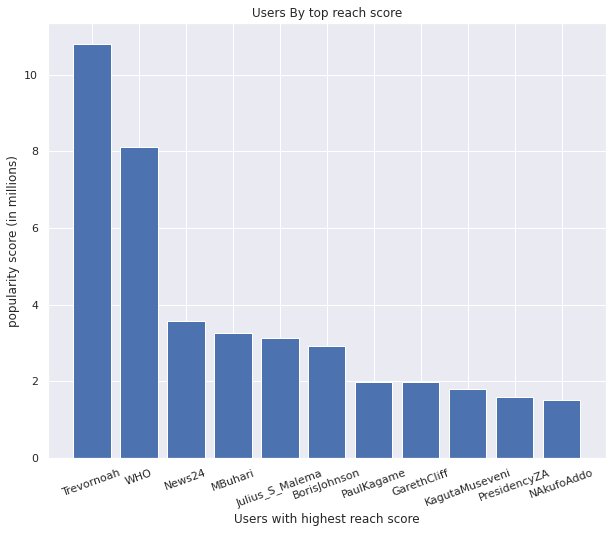

In [101]:
import matplotlib.pyplot as plt
import numpy as np

fig,ax=plt.subplots(figsize=(10,8))

x=np.arange(0,11)
y=reach_score_sorted['reach_score']/1000000

my_xticks=reach_score_sorted['original_author']

plt.xticks(x,my_xticks,rotation=20)
plt.xlabel('Users with highest reach score')
plt.ylabel('popularity score (in millions)')
plt.title('Users By top reach score')
ax.bar(x,y)
plt.show()

In [91]:
gvt_tweets.groupby(['original_author'])['statuses_count'].max()

original_author
AOuattara_PRCI       7132.0
BorisJohnson         3722.0
CheikhGhazouani        30.0
Cherif_MZ             751.0
ChitaluChilufy3         1.0
CyrilRamaphosa       4873.0
Dora_Siliya           290.0
EswatiniGovern1      1672.0
FinanceSC             125.0
GarethCliff         31624.0
IssoufouMhm           349.0
Julius_S_Malema     37194.0
KGeorgieva          18680.0
KagutaMuseveni       6644.0
MBuhari              4734.0
MSPS_Togo              44.0
M_Farmaajo            599.0
Macky_Sall           2796.0
MagufuliJP            225.0
MalawiGovt           4030.0
MinSantedj           1064.0
NAkufoAddo           7090.0
News24             322674.0
PaulKagame           2861.0
PresidenceBenin      5648.0
PresidenceMali      11167.0
Presidence_RDC       1649.0
PresidenciaCV         711.0
PresidencyZA        18853.0
Presidency_GMB       1438.0
PresidentABO         1738.0
PresidentBio           83.0
SAPresident            19.0
SouthSudanGov         209.0
StateHouseKenya      9044.0
Suda

In [92]:
likes=gvt_tweets.groupby(['original_author'])['favorite_count'].sum().sort_values(ascending=False).reset_index()
#likes.plot(kind='bar')
likes.head(5)

,original_author,favorite_count
0,BorisJohnson,12894622.0
1,Trevornoah,8098186.0
2,MBuhari,3778005.0
3,NAkufoAddo,2046145.0
4,KagutaMuseveni,1644431.0


In [93]:
retweets=gvt_tweets.groupby(['original_author'])['retweet_count'].sum().sort_values(ascending=False).reset_index()
#retweets.plot(kind='bar')
retweets.head(5)

,original_author,retweet_count
0,Trevornoah,18857355.0
1,Julius_S_Malema,5300792.0
2,BorisJohnson,3262798.0
3,MBuhari,1561996.0
4,noalaskinner,1037845.0


In [94]:
pop_score= gvt_tweets.groupby(['original_author'])["retweet_count", "favorite_count"].sum().reset_index()
pop_score['popularity_score']=pop_score['retweet_count']+pop_score['favorite_count']
pop_score_sorted=pop_score.sort_values(by='popularity_score',ascending=False)[0:11].reset_index(drop=True)
pop_score_sorted

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,original_author,retweet_count,favorite_count,popularity_score
0,Trevornoah,18857355.0,8098186.0,26955541.0
1,BorisJohnson,3262798.0,12894622.0,16157420.0
2,Julius_S_Malema,5300792.0,1233658.0,6534450.0
3,MBuhari,1561996.0,3778005.0,5340001.0
4,NAkufoAddo,694330.0,2046145.0,2740475.0
5,KagutaMuseveni,322132.0,1644431.0,1966563.0
6,CyrilRamaphosa,350830.0,1224628.0,1575458.0
7,WHO,534734.0,853930.0,1388664.0
8,SudanPMHamdok,236924.0,1088322.0,1325246.0
9,GarethCliff,1006229.0,193172.0,1199401.0


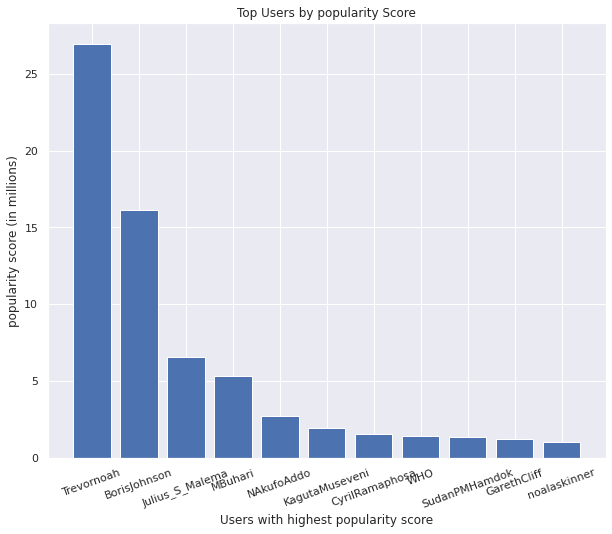

In [102]:
import matplotlib.pyplot as plt
import numpy as np

fig,ax=plt.subplots(figsize=(10,8))

x=np.arange(0,11)
y=pop_score_sorted['popularity_score']/1000000

my_xticks=pop_score_sorted['original_author']

plt.xticks(x,my_xticks,rotation=20)
plt.xlabel('Users with highest popularity score')
plt.ylabel('popularity score (in millions)')
plt.title('Top Users by popularity Score')
ax.bar(x,y)
plt.show()

In [98]:
mentions=gvt_tweets.groupby(['original_author'])['user_mentions']

In [99]:
mentions.head(5)

0                    NaN
1               KingBach
2                    NaN
3                    NaN
4        franklinleonard
              ...       
97393          MSPS_Togo
97394                NaN
97395                NaN
97396                NaN
97397                NaN
Name: user_mentions, Length: 271, dtype: object

In [100]:

gvt_tweets['user_mentions'].dropna(inplace=True)
gvt_tweets['user_mentions'].fillna(0,inplace=True)

In [ ]:
###The same for mentions
mentions_dict={}
for mention in gvt_tweets['user_mentions']:
  for singlemention in (mention.split(',')):
    authors=gvt_tweets['original_author'].unique().tolist()
    if singlemention in authors:
      if singlemention not in mentions_dict.keys():
          mentions_dict[singlemention]=1
      else:
          mentions_dict[singlemention]=mentions_dict[singlemention] +1

In [ ]:
mentions_dict

{'AOuattara_PRCI': 27,
 'BorisJohnson': 131,
 'Cherif_MZ': 2,
 'CyrilRamaphosa': 682,
 'Dora_Siliya': 1,
 'EswatiniGovern1': 1,
 'GarethCliff': 21,
 'IssoufouMhm': 81,
 'Julius_S_Malema': 20,
 'KGeorgieva': 25,
 'KagutaMuseveni': 32,
 'MBuhari': 50,
 'MSPS_Togo': 1,
 'M_Farmaajo': 14,
 'Macky_Sall': 186,
 'MagufuliJP': 140,
 'MalawiGovt': 19,
 'MinSantedj': 27,
 'NAkufoAddo': 171,
 'News24': 33,
 'PaulKagame': 82,
 'PresidenceBenin': 204,
 'PresidenceMali': 23,
 'Presidence_RDC': 18,
 'PresidencyZA': 1542,
 'Presidency_GMB': 4,
 'PresidentABO': 15,
 'PresidentBio': 4,
 'SAPresident': 2,
 'StateHouseKenya': 11,
 'SudanPMHamdok': 2,
 'TZSpokesperson': 2,
 'Trevornoah': 17,
 'UNZambia': 95,
 'USEmbalo': 15,
 'WHO': 193,
 'angola_Mirex': 1,
 'coumbagadio_ZM': 15,
 'edmnangagwa': 13,
 'gouvbenin': 1141,
 'hagegeingob': 13,
 'hawelti': 2,
 'helenzille': 9,
 'mohzambia': 88,
 'noalaskinner': 61,
 'president_gn': 2,
 'rochkaborepf': 59,
 'unicefzambia': 269,
 'willynyamitwe': 5}

In [ ]:
relevance_score=pd.DataFrame(mentions_dict.items(),columns=['original_authors','num_mentions'])
relevance_score.sort_values(by='num_mentions',ascending=False).head(15).reset_index(drop=True)

,original_authors,num_mentions
0,PresidencyZA,1542
1,gouvbenin,1141
2,CyrilRamaphosa,682
3,unicefzambia,269
4,PresidenceBenin,204
5,WHO,193
6,Macky_Sall,186
7,NAkufoAddo,171
8,MagufuliJP,140
9,BorisJohnson,131


In [ ]:
##create an ordered list of tuples with the most mentioned users and the number of times they have been mentioned

mentions_ordered_list=sorted(mentions_dict.items(),key=lambda x:x[1])
mentions_ordered_list=mentions_ordered_list[::-1]


##pick top 20 mentioned users to plot and seperate the previous list into two lists:one with users and the other with values:
mentions_ordered_values=[]
mentions_ordered_keys=[]
for item in mentions_ordered_list[0:20]:
  mentions_ordered_keys.append(item[0])
  mentions_ordered_values.append(item[1])
  


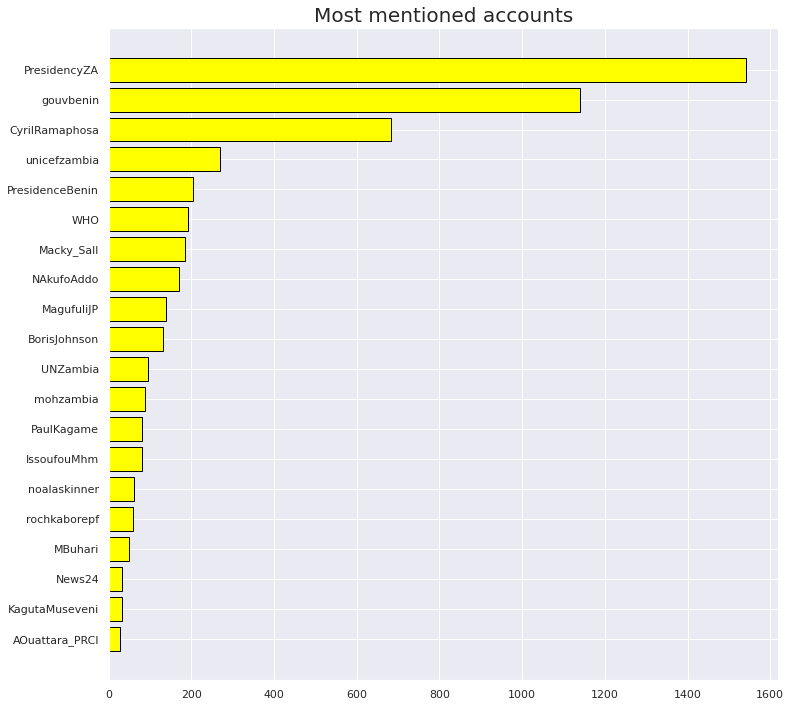

In [ ]:
#plot
import numpy as np 

fig,ax=plt.subplots(figsize=(12,12))
y_pos=np.arange(len(mentions_ordered_values))
ax.barh(y_pos,list(mentions_ordered_values)[::-1],align='center',color='yellow',edgecolor='black',linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(mentions_ordered_keys)[::-1])
ax.set_title('Most mentioned accounts',fontsize=20)
plt.show()

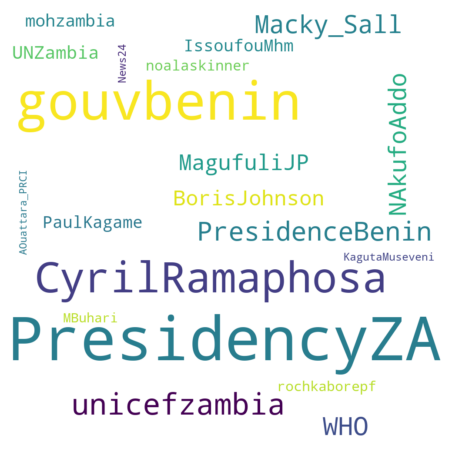

In [ ]:
##word cloud
from wordcloud import WordCloud
mentions_ordered_dict={}
for item in mentions_ordered_list[0:20]:
  mentions_ordered_dict[item[0]]=item[1]
wordcloud=WordCloud(width=1000,height=1000,random_state=21,max_font_size=200,background_color='white').generate_from_frequencies(mentions_ordered_dict)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

plt.show()

### Search twitter and fetch data example

In [ ]:
covid_keywords = '#Ethiopia'  #hashtag based search
tweets_file = 'data/ethiopia_3july2020.json'


##get data on keywords
if os.path.exists(tweets_file):
    #get file if you have already downloaded what you wanted
    df = pd.read_csv(tweets_file, header=0)
    if 'timestamp' in df.columns:
        df['timestamp'] = df.created_at.map(pd.Timestamp)
        df = df.sort_values('timestamp').set_index('timestamp')
        df = df.drop('id',axis=1)    
else:
    ts = tweetsearch()
    df = ts.get_tweets(covid_keywords, csvfile=tweets_file)    #you saved the 

In [ ]:
#df = df.set_index('timestamp')

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36791 entries, 2020-06-25 14:28:48+00:00 to 2020-07-04 07:47:03+00:00
Data columns (total 16 columns):
created_at                36791 non-null object
source                    36788 non-null object
original_text             36791 non-null object
clean_text                33708 non-null object
sentiment                 36791 non-null object
polarity                  36791 non-null float64
subjectivity              36791 non-null float64
lang                      36791 non-null object
favorite_count            36791 non-null int64
retweet_count             36791 non-null int64
original_author           36791 non-null object
possibly_sensitive        10561 non-null object
hashtags                  32042 non-null object
user_mentions             29412 non-null object
place                     220 non-null object
place_coord_boundaries    23002 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 4.8+ MB


In [ ]:
df.groupby('hashtags').source.count()

hashtags
0dam, Ethiopia, Egypt                                                                                                                                                                                               1
100days, Ethiopia, awakening, pandemic, LosAngelesProtest                                                                                                                                                           1
100days, headshot, COVID19, ChineseAppsBlocked, TuesdayMotivation, tuesdayvibes, tiktokbanindia, Ethiopia                                                                                                           1
10k, again, morningrun, uraelchurch, leipzigsquare, PMoffice, piazza, churchillroad, meskelsquare, sightseeing, addisababa, mycity, ethiopia, landoforigins, seeyousoon                                             1
10yrPlanEthiopia, Ethiopia                                                                                                             

Text(0, 0.5, 'Number of Tweets')

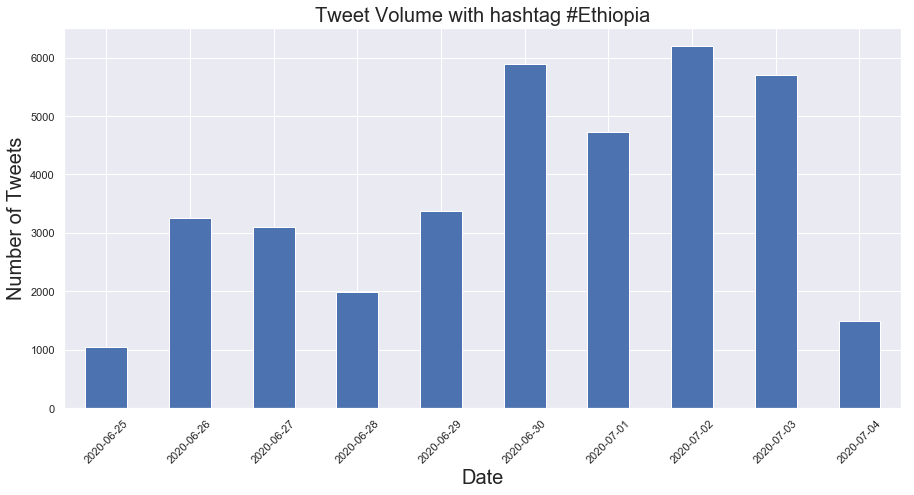

In [ ]:
#plot data
#plot data
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Tweet Volume with hashtag #Ethiopia', fontsize=20)
df.groupby(df.index.map(lambda x:x.date())).source.count().plot.bar(rot=45)
#set major ticks format
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Number of Tweets', fontsize=20)

# fig, ax = plt.subplots(figsize=(15,7))
# ax.set_title('Tweet Volume', fontsize=20)
# df.groupby('hashtags').source.count().plot.bar(rot=45)
# #set major ticks format
# #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# ax.set_xlabel('Hashtags', fontsize=20)
# ax.set_ylabel('Number of Tweets', fontsize=20)

Text(0, 0.5, 'Sentiment Score')

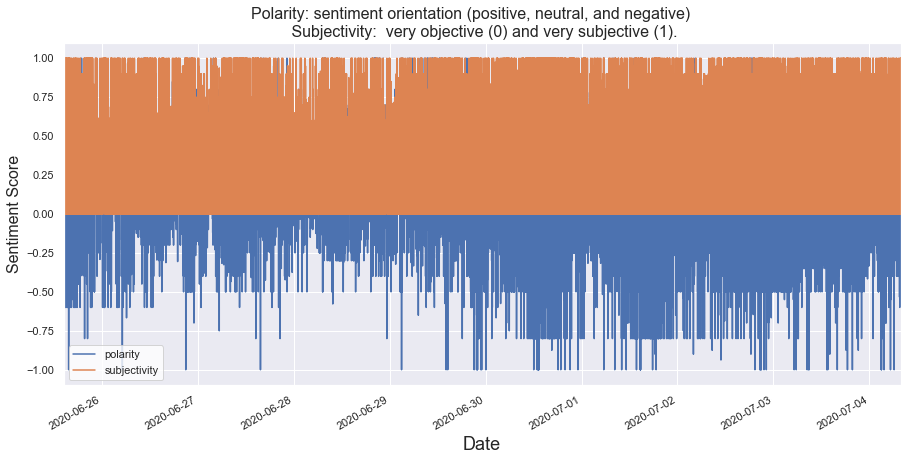

In [ ]:
#df.info()
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Polarity: sentiment orientation (positive, neutral, and negative) \
    \n Subjectivity:  very objective (0) and very subjective (1).', fontsize=16)
with sns.axes_style("whitegrid"):
    df[['polarity','subjectivity']].plot(ax=ax)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Sentiment Score', fontsize=16)

Text(0, 0.5, 'Number of Tweets')

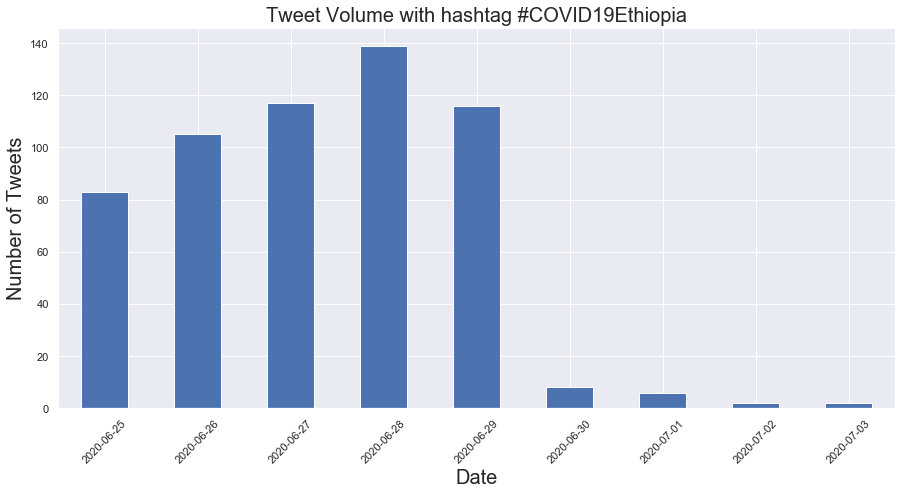

In [ ]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Tweet Volume with hashtag #COVID19Ethiopia', fontsize=20)
df.groupby(df.index.map(lambda x:x.date())).source.count().plot.bar(rot=45)
#set major ticks format
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Number of Tweets', fontsize=20)

In [ ]:
print_full(df['original_text'].unique())

['How can farmers in Ethiopia work safe and smart during COVID-19 lockdown? - @IIED | #Ethiopia #COVID19Ethiopia | https://t.co/nAYUhFonVO'
 "The last report on #COVID19Ethiopia by the Health Ministry of Ethiopia🇪🇹was on June 29th. \n\nIt's due to the break out of protests in several towns across #Ethiopia after the killing of #HachaluHundessa, a popular Oromo singer. Internet services is also shutdown across the country https://t.co/crbMs7rY6p"
 '#COVID19Ethiopia updates https://t.co/riKf2nBqo4'
 'RT @amggebre: Please STOP inciting the youth to carry out violent acts! That is a cardinal sin! An insane act that will harm the youth!\n#Et…'
 'Please STOP inciting the youth to carry out violent acts! That is a cardinal sin! An insane act that will harm the youth!\n#Ethiopia needs peace and calm to fight #covid19ethiopia https://t.co/bJiy5yDxuF'
 '@France24_en Condolences #SafetyFirst #PysicalDistancing  bitter though,there shall be time to react appropriately for positive change once Air 

## Stream data and save it to file
In the above we saw how to search and fetch data, below we will see how we will stream data from twitter. Make sure you understand the difference between search and stream features of twitter api.

### **SAME TASK AS ABOVE**


In [ ]:
#This is a basic listener that writes received tweets to file.
class StdOutListener(StreamListener):

    def __init__(self,fhandle, stop_at = 1000):
        self.tweet_counter = 0
        self.stop_at = stop_at
        self.fhandle = fhandle
         
        
    def on_data(self, data):
        self.fhandle.write(data)
        
        #stop if enough tweets are obtained
        self.tweet_counter += 1   
        if self.tweet_counter < self.stop_at:        
            return True
        else:
            print('Max number of tweets reached: #tweets = ' + str(self.tweet_counter))
            return False

    def on_error(self, status):
        print (status)

def stream_tweet_data(filename='data/tweets.json',
                      keywords=['COVID19KE'],
                      is_async=False):
    # tweet topics to use as a filter. The tweets downloaded
    # will have one of the topics in their text or hashtag 

    print('saving data to file: ',filename)

    #print the tweet topics 
    print('Tweet Keywords are: ',keywords)
    print('For testing case, please interupt the downloading process \
            using ctrl+x after about 5 mins ')
    print('To keep streaming in the background, pass is_async=True')

    #Variables that contains the user credentials to access Twitter API 
    consumer_key = os.environ.get('TWITTER_API_KEY')
    consumer_secret = os.environ.get('TWITTER_API_SECRET')
    access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
    access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
    

    #open file 
    fhandle=open(filename,'w')

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener(fhandle)
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    stream = Stream(auth, l)

    #This line filter Twitter Streams to capture data by the keywords: first argument to this code
    stream.filter(track=keywords,is_async=is_async)

    return None



### Use case of the above code

In [ ]:
tweets_file = 'data/covid19_1july2020.json'
stream_tweet_data(filename=tweets_file,keywords=['covid19'])  

### Filter twitter data and do basic analysis
**Extend it to gain more insight**

In [ ]:
tweets_data = []
for line in open(tweets_file, "r"):
    try:
        tweet = json.loads(line)
        x=tweet['text']
        tweets_data.append(tweet)
    except:
        continue


print('saved numbers of tweets: ', len(tweets_data))

saved numbers of tweets:  1000


In [ ]:
tweets = pd.DataFrame(columns=['text','lang','country'])

tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
tweets['country'] = list(map(lambda tweet: tweet['place']['country'] \
                             if tweet['place'] != None else None, 
                             tweets_data))


tweets_by_lang = tweets['lang'].value_counts()
tweets_by_lang

In [ ]:
tweets_by_country = tweets['country'].value_counts()
tweets_by_country

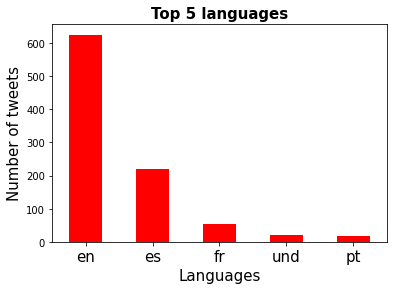

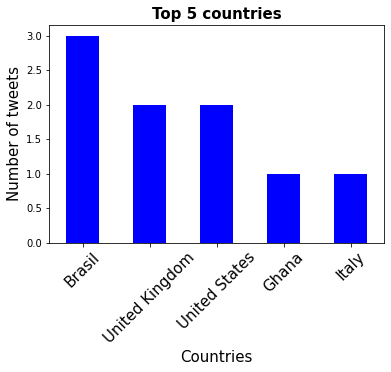

In [ ]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red', rot=0)

tweets_by_country = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue', rot=45)

# Hashtag histogram. 

## Please write code that will help you answer the following questions
 1) What is the most used hashtag?

 2) What is the most used referenced username?

 3) What is the most retweeted tweet?